In [1]:
import datetime
import os
import mthree
import numpy as np
from qiskit import Aer, IBMQ, transpile
from qiskit.providers.ibmq import IBMQBackend
from qiskit_research.mzm_generation import KitaevHamiltonianExperiment
from qiskit_research.mzm_generation.experiment import CircuitParameters

In [2]:
# get backend

# hardware backend
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibmq_lima')

# simulator backend
# backend = Aer.get_backend("statevector_simulator")

In [3]:
# Hamiltonian parameters
n_modes = 3
tunneling_values = [-1.0]
superconducting_values = [0.5, 1.0]
chemical_potential_values = np.linspace(1e-8, 3.1, num=20)
occupied_orbitals_list = [(), (0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)]

# qubits
# TODO choose qubits that minimize error rate
qubits = [0, 1, 2]

# number of shots
shots = 50000

# number of shots for readout error calibration
readout_calibration_shots = 100000

# experiment id used for saving data
experiment_id = f'{datetime.datetime.now().isoformat()}_{backend.name()}'

# create experiment
experiment = KitaevHamiltonianExperiment(
    experiment_id=experiment_id,
    qubits=qubits,
    tunneling_values=tunneling_values,
    superconducting_values=superconducting_values,
    chemical_potential_values=chemical_potential_values,
    occupied_orbitals_list=occupied_orbitals_list,
)

In [4]:
# schedule readout calibration
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(qubits, shots=readout_calibration_shots)

# schedule experiment jobs
data = experiment.run(backend=backend, shots=shots)
if isinstance(backend, IBMQBackend):
    data.save()

You can view the experiment online at https://quantum-computing.ibm.com/experiments/649d7a70-c843-4591-924a-aa6d7eb6bb09


In [5]:
# save readout calibration
filename = f'data/{experiment_id}/readout_calibration.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
mit.cals_to_file(filename)
print(f'Readout calibration saved.')

Readout calibration saved.


In [ ]:
# wait for experiment results
data.block_for_results()

# TODO save data locally once it's supported
# See https://github.com/Qiskit/qiskit-experiments/issues/602

In [1]:
# TODO split off into analysis notebook once Qiskit Experiments supports saving data
# See https://github.com/Qiskit/qiskit-experiments/issues/602
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ
from qiskit_experiments.framework import ExperimentData
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_research.mzm_generation import KitaevHamiltonianAnalysis

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')

In [3]:
# db_experiment_id = '0c062b9e-42dc-4234-8d98-ad7c4009e42e'
db_experiment_id = '9e7e2259-35c1-412c-92ce-eb3daed8ff6a'
# db_experiment_id = 'c09ecdc3-1ddf-43a4-9ad5-77332e6618e1'

data = ExperimentData.load(db_experiment_id, provider.service('experiment'))

In [4]:
qubits = data.metadata["qubits"]
n_modes = len(qubits)
tunneling_values = data.metadata["tunneling_values"]
superconducting_values = data.metadata["superconducting_values"]
chemical_potential_values = data.metadata["chemical_potential_values"]

# run analysis
analysis = KitaevHamiltonianAnalysis()
data = analysis.run(data)

# load results
energy_exact = data.analysis_results('energy_exact').value
energy_raw = data.analysis_results('energy_raw').value
energy_mem = data.analysis_results('energy_mem').value
energy_ps = data.analysis_results('energy_ps').value
energy_pauli_basis_raw = data.analysis_results('energy_pauli_basis_raw').value
energy_pauli_basis_mem = data.analysis_results('energy_pauli_basis_mem').value
energy_error_raw, energy_error_stddev_raw = data.analysis_results('energy_error_raw').value
energy_error_mem, energy_error_stddev_mem = data.analysis_results('energy_error_mem').value
energy_error_ps, energy_error_stddev_ps = data.analysis_results('energy_error_ps').value
energy_error_pauli_basis_raw, energy_error_pauli_basis_stddev_raw = data.analysis_results('energy_error_pauli_basis_raw').value
energy_error_pauli_basis_mem, energy_error_pauli_basis_stddev_mem = data.analysis_results('energy_error_pauli_basis_mem').value

/home/kjs/projects/qiskit-research/qiskit_research/mzm_generation/utils.py:31: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp(f"-_{index}") + FermionicOp(f"+_{index}")


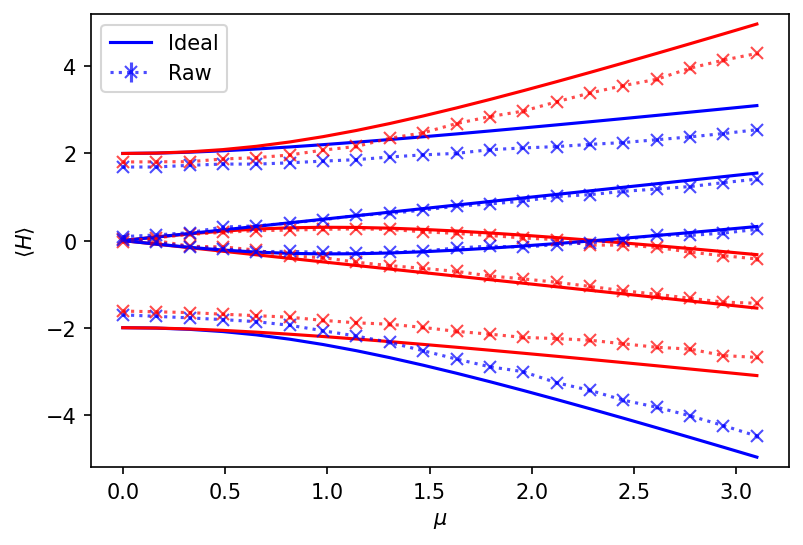

In [5]:
dpi = 150

# plot energy, raw data only
fig, ax = plt.subplots(dpi=150)
for occupied_orbitals, energies in energy_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        chemical_potential_values, energies, label=label, color=color
    )
for occupied_orbitals, (energies, stddevs) in energy_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
ax.set_ylim(-5.2, 5.2)
ax.legend()

data.add_figures(fig, 'energy_raw', overwrite=True)
plt.show()

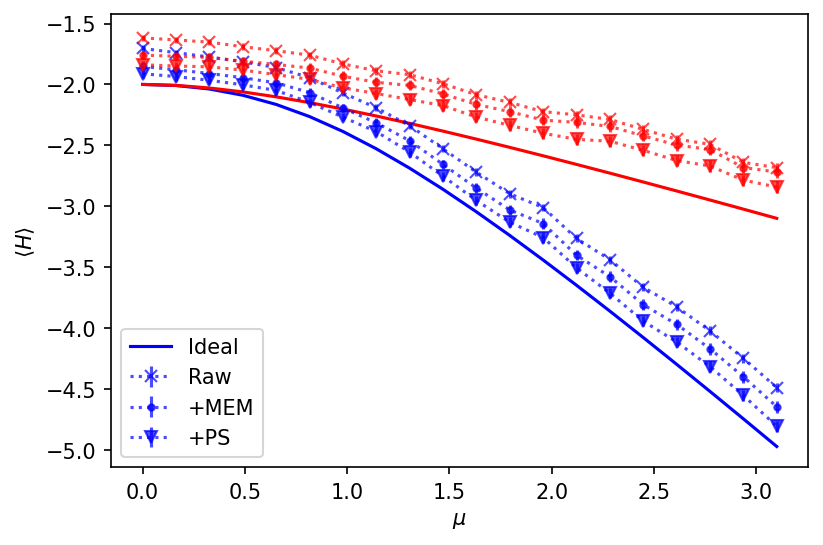

In [6]:
# plot energy, raw data plus error mitigation
fig, ax = plt.subplots(dpi=dpi)
occupied_orbitals_list = [(), (0,)]
for occupied_orbitals in occupied_orbitals_list:
    energies = energy_exact[occupied_orbitals]
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        chemical_potential_values, energies, label=label, color=color
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_raw[occupied_orbitals]
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_mem[occupied_orbitals]
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt=".:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_ps[occupied_orbitals]
    label = "+PS" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="v:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
#ax.set_ylim(-5.2, -1)
ax.legend()

data.add_figures(fig, 'energy_mit', overwrite=True)
plt.show()

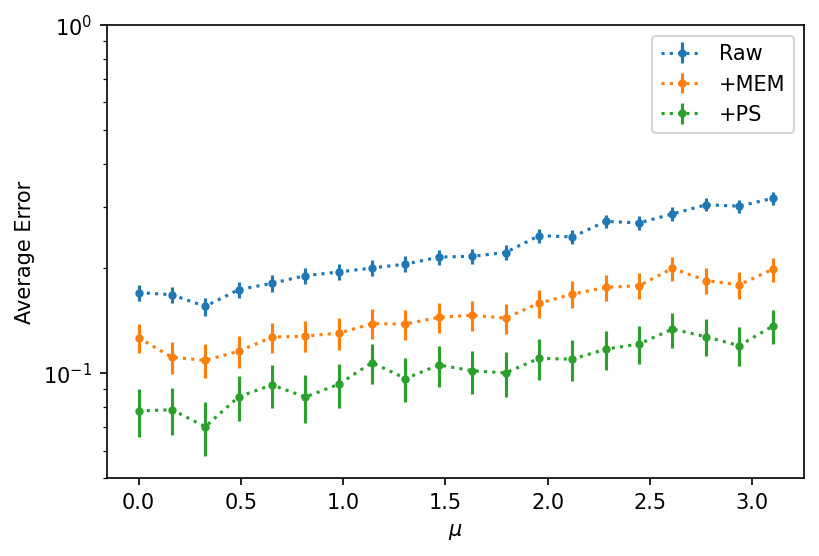

In [7]:
# plot average error in energy
fig, ax = plt.subplots(dpi=dpi)
ax.errorbar(
    chemical_potential_values,
    energy_error_raw,
    yerr=2 * energy_error_stddev_raw,
    fmt=".:",
    label="Raw",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_mem,
    yerr=2 * energy_error_stddev_mem,
    fmt=".:",
    label="+MEM",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_ps,
    yerr=2 * energy_error_stddev_ps,
    fmt=".:",
    label="+PS",
)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"Average Error")
ax.set_yscale('log')
ax.set_ylim(5e-2, 1)
ax.legend()

data.add_figures(fig, 'energy_error_mit', overwrite=True)
plt.show()

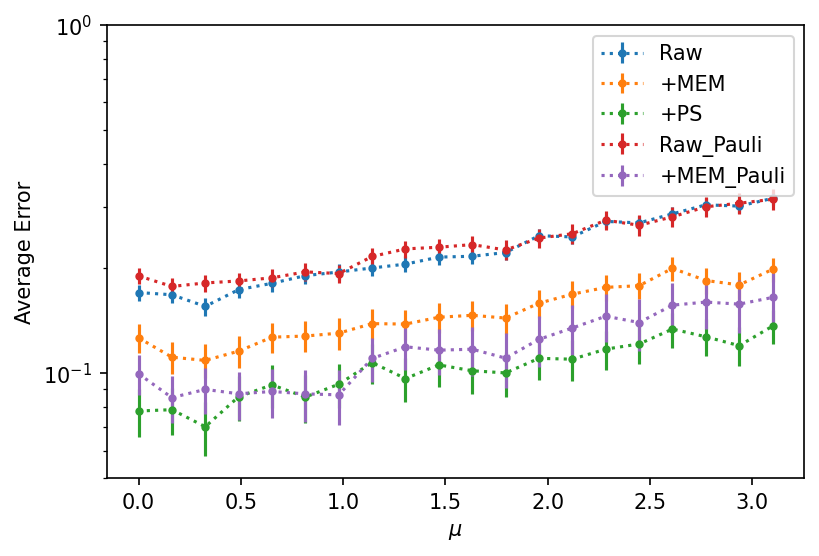

In [8]:
# plot average error in energy, pauli vs parity basis
fig, ax = plt.subplots(dpi=dpi)
ax.errorbar(
    chemical_potential_values,
    energy_error_raw,
    yerr=2 * energy_error_stddev_raw,
    fmt=".:",
    label="Raw",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_mem,
    yerr=2 * energy_error_stddev_mem,
    fmt=".:",
    label="+MEM",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_ps,
    yerr=2 * energy_error_stddev_ps,
    fmt=".:",
    label="+PS",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_pauli_basis_raw,
    yerr=2 * energy_error_pauli_basis_stddev_raw,
    fmt=".:",
    label="Raw_Pauli",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_pauli_basis_mem,
    yerr=2 * energy_error_pauli_basis_stddev_mem,
    fmt=".:",
    label="+MEM_Pauli",
)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"Average Error")
ax.set_yscale('log')
ax.set_ylim(5e-2, 1)
ax.legend()

data.add_figures(fig, 'energy_error_pauli_vs_pb', overwrite=True)
plt.show()

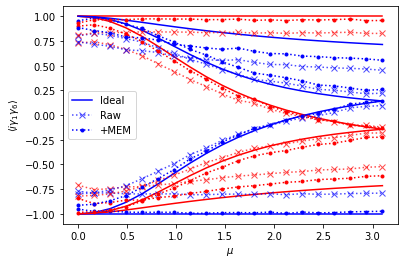

In [14]:
# plot edge correlation
edge_correlation_exact = data.analysis_results('edge_correlation_exact').value
edge_correlation_raw = data.analysis_results('edge_correlation_raw').value
edge_correlation_mem = data.analysis_results('edge_correlation_mem').value

fig, ax = plt.subplots()
for occupied_orbitals, series in edge_correlation_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(chemical_potential_values, series, label=label, color=color)
for occupied_orbitals, series in edge_correlation_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        chemical_potential_values,
        series,
        "x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals, series in edge_correlation_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        chemical_potential_values, series, ".:", label=label, color=color
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle i \gamma_1 \gamma_6 \rangle$")
ax.set_ylim(-1.1, 1.1)
ax.legend()

data.add_figures(fig, 'edge_correlation_raw_mem', overwrite=True)
plt.show()

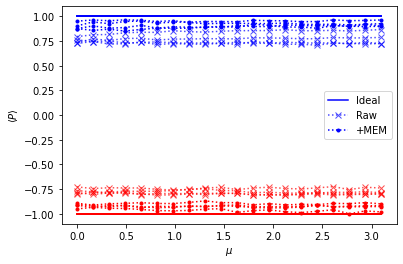

In [11]:
# plot parity
parity_exact = data.analysis_results('parity_exact').value
parity_raw = data.analysis_results('parity_raw').value
parity_mem = data.analysis_results('parity_mem').value
fig, ax = plt.subplots()
for occupied_orbitals, series in parity_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(chemical_potential_values, series, label=label, color=color)
for occupied_orbitals, series in parity_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        chemical_potential_values,
        series,
        "x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals, series in parity_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        chemical_potential_values, series, ".:", label=label, color=color
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle P \rangle$")
ax.set_ylim(-1.1, 1.1)
ax.legend()

data.add_figures(fig, 'parity_raw_mem', overwrite=True)
plt.show()

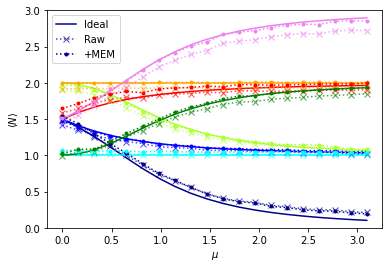

In [12]:
# plot number
number_exact = data.analysis_results('number_exact').value
number_raw = data.analysis_results('number_raw').value
number_mem = data.analysis_results('number_mem').value

fig, ax = plt.subplots()
colors = {
    (): "darkblue",
    (0,): "blue",
    (1,): "cyan",
    (2,): "greenyellow",
    (0, 1): "green",
    (0, 2): "orange",
    (1, 2): "red",
    (0, 1, 2): "violet",
}
for occupied_orbitals, series in number_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    ax.plot(
        chemical_potential_values,
        series,
        label=label,
        color=colors[occupied_orbitals],
    )
for occupied_orbitals, series in number_raw.items():
    label = "Raw" if not occupied_orbitals else None
    ax.plot(
        chemical_potential_values,
        series,
        "x:",
        label=label,
        color=colors[occupied_orbitals],
        alpha=0.7,
    )
for occupied_orbitals, series in number_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    ax.plot(
        chemical_potential_values,
        series,
        ".:",
        label=label,
        color=colors[occupied_orbitals],
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle N \rangle$")
ax.set_ylim(0, 3)
ax.legend()

data.add_figures(fig, 'number_raw_mem', overwrite=True)
plt.show()